In [3]:
import unicodedata
from collections import Counter

import pandas as pd
import nltk
from matplotlib import pyplot as plt
import seaborn as sns
from googletrans import Translator

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/zain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
translator = Translator()

In [5]:
sns.set()

# A color blind safe palette that goes well with the background
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

# Lighter background to help with review categories' colors
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

# Default figure size
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [6]:
orders = pd.read_csv('olist_orders_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

In [7]:
reviews = pd.merge(reviews, orders, on='order_id')

In [8]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
STOP_WORDS.remove('nao') # This word is key to understand delivery problems later


def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    resize_plot()
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)

In [9]:
commented_reviews = reviews[reviews['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_4s = commented_reviews[commented_reviews['review_score'] == 4]
reviews_3s = commented_reviews[commented_reviews['review_score'] == 3]
reviews_2s = commented_reviews[commented_reviews['review_score'] == 2]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_4s, bigrams_4s, trigrams_4s = words_to_ngrams(reviews_4s['review_comment_words'])
unigrams_3s, bigrams_3s, trigrams_3s = words_to_ngrams(reviews_3s['review_comment_words'])
unigrams_2s, bigrams_2s, trigrams_2s = words_to_ngrams(reviews_2s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

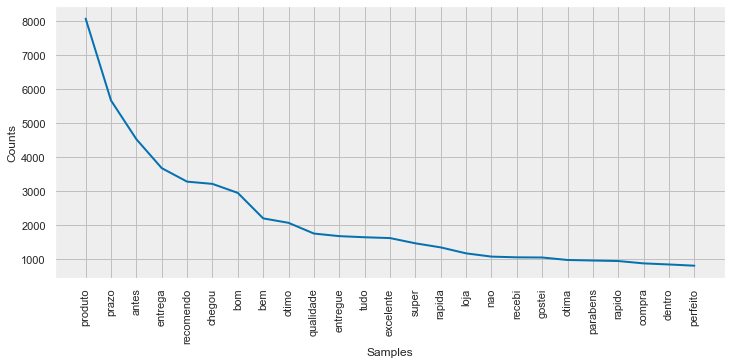

In [14]:
plot_freq(unigrams_5s, COLOR_5S)

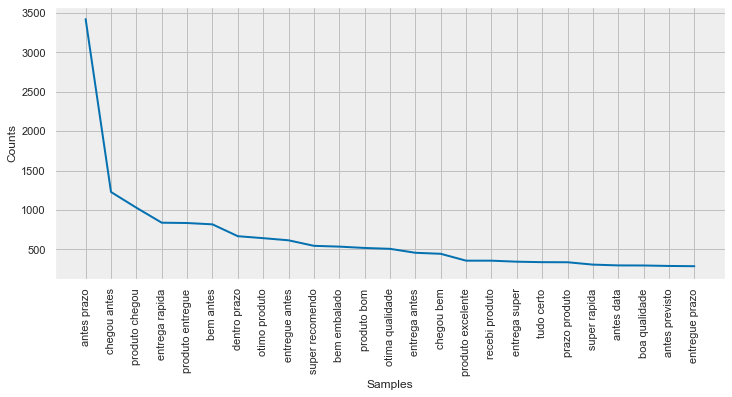

In [15]:
plot_freq(bigrams_5s, COLOR_5S)

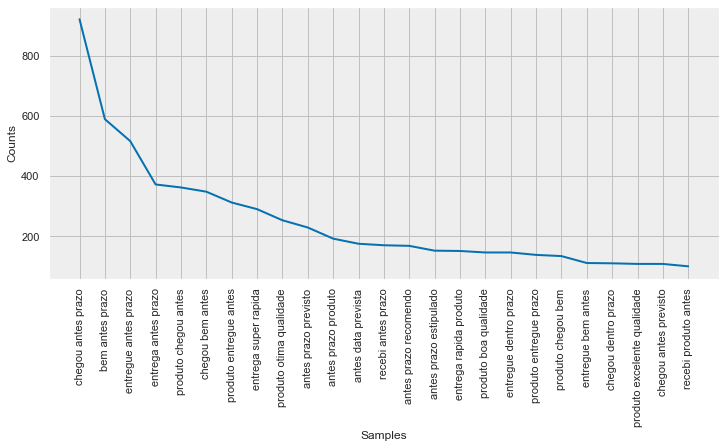

In [16]:
plot_freq(trigrams_5s, COLOR_5S)

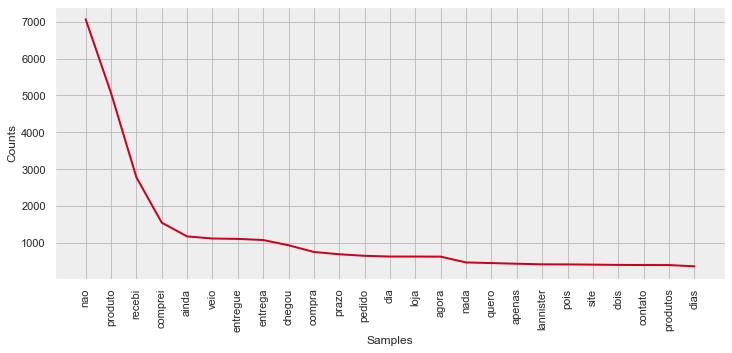

In [17]:
plot_freq(unigrams_1s, COLOR_1S)

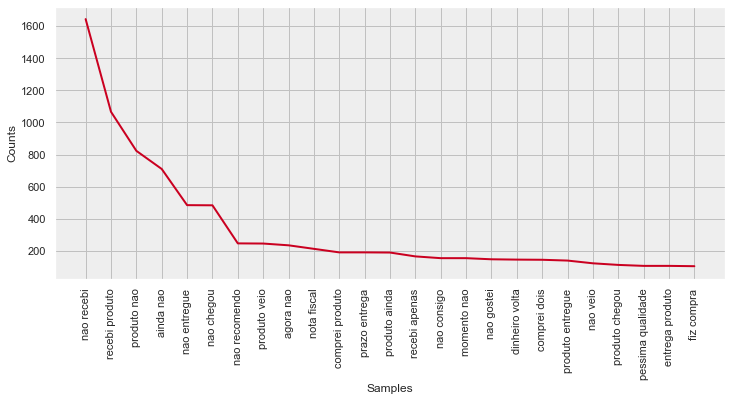

In [18]:
plot_freq(bigrams_1s, COLOR_1S)

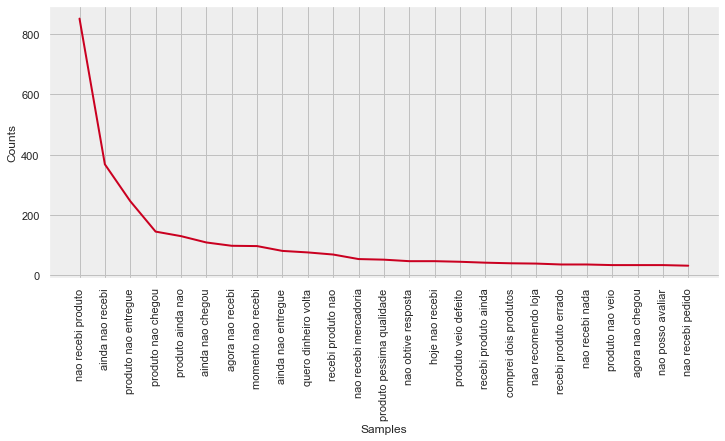

In [19]:
plot_freq(trigrams_1s, COLOR_1S)

In [17]:
def count_and_translate(words, star):
    counter = Counter(words).most_common()
    df = pd.DataFrame(counter, columns = ['word', 'total'])
    df = df[:10]
    word_en = df['word'].apply(lambda x: translator.translate(x).text)
    df.insert(1, 'word_en', word_en)
    df['star'] = star

    return df

In [19]:
bigrams_5s_en = count_and_translate(bigrams_5s, 5)
trigrams_5s_en = count_and_translate(trigrams_5s, 5)
bigrams_4s_en = count_and_translate(bigrams_4s, 4)
trigrams_4s_en = count_and_translate(trigrams_4s, 4)
bigrams_3s_en = count_and_translate(bigrams_3s, 3)
trigrams_3s_en = count_and_translate(trigrams_3s, 3)
bigrams_2s_en = count_and_translate(bigrams_2s, 2)
trigrams_2s_en = count_and_translate(trigrams_2s, 2)
bigrams_1s_en = count_and_translate(bigrams_1s, 1)
trigrams_1s_en = count_and_translate(trigrams_1s, 1)

result = pd.concat([
    bigrams_5s_en,
    trigrams_5s_en,
    bigrams_4s_en,
    trigrams_4s_en,
    bigrams_3s_en,
    trigrams_3s_en,
    bigrams_2s_en,
    trigrams_2s_en,
    bigrams_1s_en,
    trigrams_1s_en
])

result

,word,word_en,total,star
0,antes prazo,termination,3418,5
1,chegou antes,arrived before,1228,5
2,produto chegou,Product arrived,1029,5
3,entrega rapida,fast delivery,839,5
4,produto entregue,product delivered,835,5
...,...,...,...,...
5,ainda nao chegou,it did not arrive yet,109,1
6,agora nao recebi,now I did not receive,98,1
7,momento nao recebi,moment I did not receive,97,1
8,ainda nao entregue,not delivered,81,1


In [20]:
result.to_excel('revies.xlsx')